# Self-Driving Car Hacktorial

## Project Goal: Train a Deep Neural Network to steer a simulated car using only images of what the car sees on the road as an input.

All the main code here is nicely formatted and runnable in [model.py](/model.py). This notebook is just to visualize the data and walkthrought the entire process with code explanations. A writeup of the tutorial is available to view on Medium [here](https://medium.com/decode-ways).

## 1. Setup

Some basic setup for the rest of the project.

### Imports

In [4]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals

import argparse
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.misc

from IPython.display import display
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation, Dense, Dropout, Flatten, Lambda, Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.models import Sequential
from keras.optimizers import Adam
from PIL import Image
from sklearn.model_selection import train_test_split

%matplotlib inline

### Constants

In [35]:
kSEED = 5
SIDE_STEERING_CONSTANT = 0.25
NUM_BINS = 23
NB_EPOCH = 15
LR = 1e-3

## 2. Data Analysis

In this section we analayze all the training data before we preprocess it and feed it into the model to train on. The data here is provided by Udacity but you can also create your own using the simulator train option. It is reccomended to try driving in "recovery" paths so the car learns that when you are on the side of the road you should maneuver back to the center.

### Load data

In [24]:
# Location of the training data from Udacity.
file_name = 'driving_log.csv'
columns = [
    'Center Image',
    'Left Image',
    'Right Image',
    'Steering Angle',
    'Throttle',
    'Break',
    'Speed']

data = pd.read_csv(file_name, names=columns, header=0)
data[columns[:3]] = data[columns[:3]].astype(str)
data[columns[3:]] = data[columns[3:]].astype(float)
angles = data[columns[3]]

### What the data looks like

In [25]:
display(data.head())

,Center Image,Left Image,Right Image,Steering Angle,Throttle,Break,Speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


### Data Statistics

It's always important to understand basic statistics about the data you will train on to avoid any bias. With pandas, it's super easy to analyze the data. Let's analyze the float values and also plot the steering angles to identify any potential biases.

In [26]:
display(data.describe())

,Steering Angle,Throttle,Break,Speed
count,8036.000000,8036.000000,8036.000000,8036.000000
mean,0.004070,0.869660,0.001970,28.169839
std,0.128840,0.301326,0.036565,6.149327
min,-0.942695,0.000000,0.000000,0.502490
25%,0.000000,0.985533,0.000000,30.183093
50%,0.000000,0.985533,0.000000,30.186400
75%,0.000000,0.985533,0.000000,30.186640
max,1.000000,0.985533,1.000000,30.709360


Lets plot a histogram of the steering angles to get a better idea of how many examples we have for each angle.

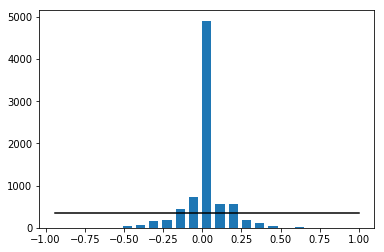

In [27]:
num_bins = 23
avg_samples_per_bin = len(data['Steering Angle'])/num_bins
hist, bins = np.histogram(data['Steering Angle'], num_bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(angles), np.max(angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')

### Interesting Observations

1. Steering angle varies between -1.0 and 1.0 but its almost always 0 (driving straight). This is not good as then our model would be biased to driving straight.
2. The car was driven at it's maximum speed most of the time.
3. The throttle was barely adjusted while driving and same with the breaking which was rarely applied.
4. Steering data is biased towards turning left.

### Data pre-processing

Let's fix our training data to get rid of our bias to driving straight and turning left. We can use some statistical probability techniques here to make the data look more even for each example. The following code computes probabilities for each bin and drops random samples (higher probability of being dropped if closer to 0).

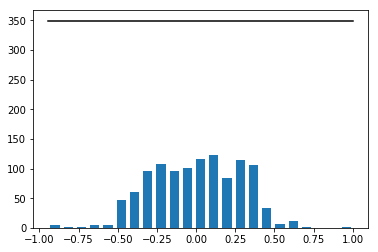

In [28]:
keep_probs = []
target = avg_samples_per_bin * .3
for i in range(num_bins):
    if hist[i] < target:
        keep_probs.append(1.)
    else:
        keep_probs.append(1./(hist[i]/target))
        
remove_list = []
for i in range(len(data['Steering Angle'])):
    for j in range(num_bins):
        if data['Steering Angle'][i] > bins[j] and data['Steering Angle'][i] <= bins[j+1]:
            # delete from X and y with probability 1 - keep_probs[j]
            if np.random.rand() > keep_probs[j]:
                remove_list.append(i)
data.drop(data.index[remove_list], inplace=True)

# print histogram again to show more even distribution of steering angles
hist, bins = np.histogram(data['Steering Angle'], num_bins)
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(data['Steering Angle']), np.max(data['Steering Angle'])), (avg_samples_per_bin, avg_samples_per_bin), 'k-')

### Sample Images of training data.

These are three samples from the same time momement in the simulation. Notice how the edges and lanes are more visible in the right and left cameras. We will train our model using all three cameras but our final model for prediction will only use our center camera for simplicity. We also need to modify the steering angle by adding and subtracting a small constant for the left and right images to handle the shift.

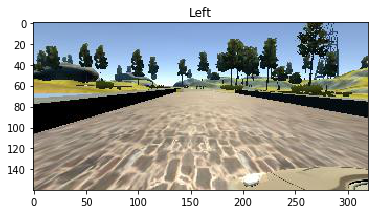

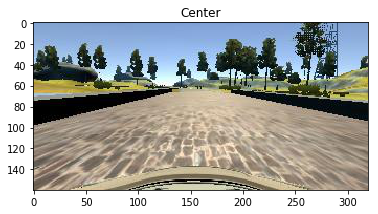

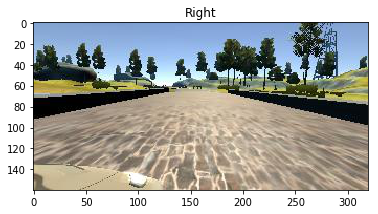

In [29]:
left_image = Image.open('images/left.jpg')
_ = plt.imshow(left_image)
plt.title('Left')
plt.show()

center_image = Image.open('images/center.jpg')
_ = plt.imshow(center_image)
plt.title('Center')
plt.show()

right_image = Image.open('images/right.jpg')
_ = plt.imshow(right_image)
plt.title('Right')
plt.show()

## Train-Test split

Here we use 85% of the data to train and 15% to validate our model. This is a common practice when training machine learning models.

In [30]:
images = data[columns[:3]]
angles = data[columns[3]]

X_train, X_val, y_train, y_val = train_test_split(images, angles, test_size=0.15, random_state=kSEED)

## 3. Data Augmentation



### Helper augmentation image functions

We have four helper image functions detailed below:

1. load_image: Loads an image from disk.
2. flip_image: Loads an image from disk and flips it to give an example of steering in the opposite direction.
3. tint_image: Loads an image from disk and tints it to make it look like the car is driving during a different time of day (helps deal with driving at night).
4. jitter_image: Open image from disk and jitters it and modifies new angle. This is to simulate being on a different position on the track at that time.
5. resize_crop: Crops the image to focus only on road and then resizes it.

In [31]:
def resize_crop(img):
    """
    Crops the image to focus only on road and then resizes it.

    :param img: Image to crop and resize.

    :return: A cropped image.
    """
    img = np.array(img, np.float32)
    img = img[35:135, :]
    img = scipy.misc.imresize(img, (66, 200))
    return img


def jitter_image(path, steering):
    """
    Open image from disk and jitters it and modifies new angle.

    :param path: Path of image.
    :param steering: Steering angle corresponding to image.

    :return: Jittered image and new steering angle.
    """
    img = cv2.imread(path.strip())
    rows, cols, _ = img.shape
    transRange = 100
    numPixels = 10
    valPixels = 0.4
    transX = transRange * np.random.uniform() - transRange / 2
    transY = numPixels * np.random.uniform() - numPixels / 2
    transMat = np.float32([[1, 0, transX], [0, 1, transY]])
    steering = steering + transX / transRange * 2 * valPixels
    img = cv2.warpAffine(img, transMat, (cols, rows))
    return resize_crop(img), steering


def flip_image(path):
    """
    Flips the image.

    :param path: Path of image to flip.

    :return: A flipped image.
    """
    img = Image.open(path.strip())
    img = img.transpose(Image.FLIP_LEFT_RIGHT)
    return resize_crop(img)


def tint_image(path):
    """
    Applies random tint to image to simulate night time.

    :param path: Path of image to flip.

    :return: A tinted image.
    """
    img = cv2.imread(path.strip())
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    img = np.array(img, dtype=np.float64)
    random_bright = .5 + np.random.uniform()
    img[:, :, 2] = img[:, :, 2] * random_bright
    img[:, :, 2][img[:, :, 2] > 255] = 255
    img = np.array(img, dtype=np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return resize_crop(img)


def load_image(path):
    """
    Loads an image give path.

    :param path: Path of image to flip.

    :return: An image.
    """
    img = Image.open(path.strip())
    return resize_crop(img)

### Visualize preprocessing.

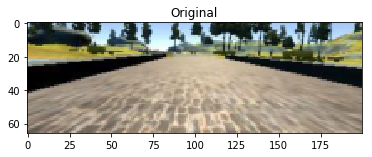

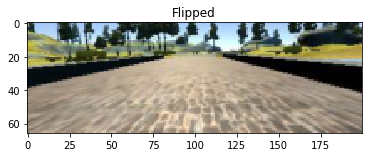

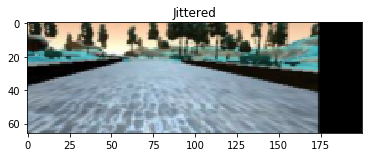

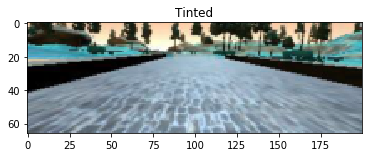

In [32]:
path = 'images/center.jpg'

original_image = load_image(path)
_ = plt.imshow(original_image)
plt.title('Original')
plt.show()

flipped_image = flip_image(path)
_ = plt.imshow(flipped_image)
plt.title('Flipped')
plt.show()

jittered_image, steering = jitter_image(path, 0.0)
_ = plt.imshow(jittered_image)
plt.title('Jittered')
plt.show()

tinted_image = tint_image(path)
_ = plt.imshow(tinted_image)
plt.title('Tinted')
plt.show()

## 4. Generate Training Data

We can create a batch generator which we will take all the data we currently have from the CSV file, augment it and pass it into our model. The goal of the batch generator is to create a data input such that for every image we have the corresponding speed. It also allows us to apply all the preproccessing we did to each image and keep it as our data.

The augment_data parameter tells us if we want to use our data augmentation methods from above on each of our training iamges. This is a good idea at training time because it gives us 5 additional examples (left, right, flipped, tinted, jittered) to supplement the center image and hence gives us more training examples. During validation time however, since we don't augument live data we avoid this and set the parameter to false.

The batch_generator which is a Keras functionality, allows us to create a custom generator that passes in batches of 64 training examples at a time for the model to train on. We can customize what data is passed in.

It would be a good idea here to create more preprocessing methods that do other things such as randomly shear an image, horizontally crop some images to limit data, darken images, etc. to create a better dataset. For the sake of this hacktorial we will limit it to only cropping and flipping.

In [33]:
def batch_generator(images, angles, augment_data=True, batch_size=64):
    """
    Keras Batch Generator to create a generator of training examples for model.

    :param images: Training image data.
    :param angles: Angle data for images.
    :param batch_size: Batch size of each training run.
    :param augment_data: If the data should be augmented.

    :return: A batch generator.
    """
    batch_images = []
    batch_angles = []
    sample_count = 0

    while True:
        # Shuffle indices to minimize overfitting.
        for i in np.random.permutation(images.shape[0]):

            # Image (1) -> Center image and steering angle.
            center_path = images.iloc[i]['Center Image']
            left_path = images.iloc[i]['Left Image']
            right_path = images.iloc[i]['Right Image']
            angle = float(angles.iloc[i])

            center_image = utils.load_image(center_path)
            batch_images.append(center_image)
            batch_angles.append(angle)

            sample_count += 1

            if augment_data:
                # Image (2) -> Flip the image and invert angle respectively.
                flipped_image = utils.flip_image(center_path)
                flipped_angle = -1.0 * angle
                batch_images.append(flipped_image)
                batch_angles.append(flipped_angle)

                # Image (3) -> Tint the center image to random brightness.
                tint_image = utils.tint_image(center_path)
                tint_angle = angle
                batch_images.append(tint_image)
                batch_angles.append(tint_angle)

                # Image (4) -> Jitter the center image to make it seem like
                # different position on the road.
                jittered_image, jitter_angle = utils.jitter_image(center_path, angle)
                batch_images.append(jittered_image)
                batch_angles.append(jitter_angle)

                # Image (5) -> Load the left image and add steering constant to
                # compensate.
                left_image = utils.load_image(left_path)
                left_angle = min(1.0, angle + SIDE_STEERING_CONSTANT)
                batch_images.append(left_image)
                batch_angles.append(left_angle)

                # Image (6) -> Load the right image and subtract steering
                # constant to compensate.
                right_image = utils.load_image(right_path)
                right_angle = max(-1.0, angle - SIDE_STEERING_CONSTANT)
                batch_images.append(right_image)
                batch_angles.append(right_angle)

            if ((sample_count % batch_size == 0) or (sample_count % len(images) == 0)):
                yield np.array(batch_images), np.array(batch_angles)
                # Reset batch/
                batch_images = []
                batch_angles = []

## 5. Building the Model

Model is based on NVIDIA's "End to End Learning for Self-Driving Cars" paper [End-to-End Deep Learning for Self-Driving Cars](https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf).

The differences between their model and ours is that we add a Maxpooling layer after every Convolutional layer to speed up computation and also have more fully-connected (dense) layers.

The model will take in an image (either from the left, center, or right camera) and output a single number between -1 and 1 representing the steering angle. We used Keras to implement the model. Keras is a deep learning library that runs on Tensorflow or Theano and is best for fast prototyping. For more intensive deep learning tasks, PyTorch or TensorFlow may be a better option.


In [37]:
model = Sequential()
# Lambda layer normalizes pixel values between 0 and 1
model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(66, 200, 3)))
# Convolutional layer (1)
model.add(Conv2D(24, (5,5), padding='same', activation='relu', strides=(2,2)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1)))
# Convolutional layer (2)
model.add(Conv2D(36, (5,5), padding='same', activation='relu', strides=(2,2)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1)))
# Convolutional layer (3)
model.add(Conv2D(48, (5,5), padding='same', activation='relu', strides=(2,2)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1)))
# Convolutional layer (4)
model.add(Conv2D(64, (3,3), padding='same', activation='relu', strides=(1,1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1)))
# Convolutional layer (5)
model.add(Conv2D(64, (3,3), padding='same', activation='relu', strides=(1,1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1)))
# Flatten Layer
model.add(Flatten())
# Dense Layer (1)
model.add(Dense(1164, activation='relu'))
# Dense layer (2)
model.add(Dense(100, activation='relu'))
# Dense layer (3)
model.add(Dense(50, activation='relu'))
# Dense layer (4)
model.add(Dense(10, activation='relu'))
# Dense layer (5)
model.add(Dense(1))
# Compile model
model.compile(optimizer=Adam(lr=LR, decay=LR / NB_EPOCH), loss='mse')

#### Model Summary

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 33, 100, 24)       1824      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 99, 24)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 50, 36)        21636     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 15, 49, 36)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 25, 48)         43248     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 24, 48)         0         
__________

## 6. Training the Model

Let's create the generators for our training and validation examples. Remember that for our validation examples, we don't augment the data.

In [39]:
generator_train = batch_generator(X_train, y_train, augment_data=True)
generator_val = batch_generator(X_val, y_val, augment_data=False)

Fit the model to the data we created from our batch generator. Here steps per epoch is the number of examples we have which is 6 times the number of training examples. We get the number six from the original 3 left, right, center examples + the three augmented examples (flipped, tinted, jittered). For the steps in validation however since we only use center images its simply how many examples we have. We train our model for 15 epochs.

In [ ]:
model.fit_generator(
        generator_train,
        steps_per_epoch=6 * len(X_train),
        epochs=NB_EPOCH,
        validation_data=generator_val,
        validation_steps=len(X_val),
        verbose=1)

We can save model for later use.

In [ ]:
model.save_weights('model.h5', True)
with open('model.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)

Visualize training loss on training and validation.

In [ ]:
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## 7. Testing the model on the simulation

Run this following command in the directory after opening up the simulator and selecting the autonomous mode option.

`python drive.py model.json`